# Bias, Varianza e Overfitting

Finora abbiamo fatto dei fit nei quali il modello di funzione usata era identico a quello che abbiamo usato per generare il campione simulato.

Esistono molti casi nei quali non c'è un modello teorico predefinito, e bisogna ispirarsi ai dati per trovare una funzione che meglio descriva i dati.

Un modello abbastanza flessibile, per diversi casi, potrebbe essere una funzione polinomiale. Più alto il il grado della polinomiale, più sarà facile "seguire" i dati in maniera accurata. Tuttavia, il grado del polinomio non può crescere all'infinito: se il numero di parametri, che è pari al grado del polinomio più uno, è pari al numero di misure, i parametri possono essere determinati univocamente senza alcun grado di libertà residuo.

Vediamo nel seguito come scegliere il numero ottimale di parametri per un modello di fit.

Introdurremo alcuni concetti e terminologie che sono importanti anche in problemi di *machine learning*.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Definiamo una funzione che rappresenta il *vero* andamento della funzione che vogliamo determinare da un fit.

In questo esempio simulato la conosciamo, ma in problemi reali non è detto che il nostro modello teorico sia noto.

In [2]:
def true_f(x):
    return 150*x*(0.06+np.exp(-0.15*x))

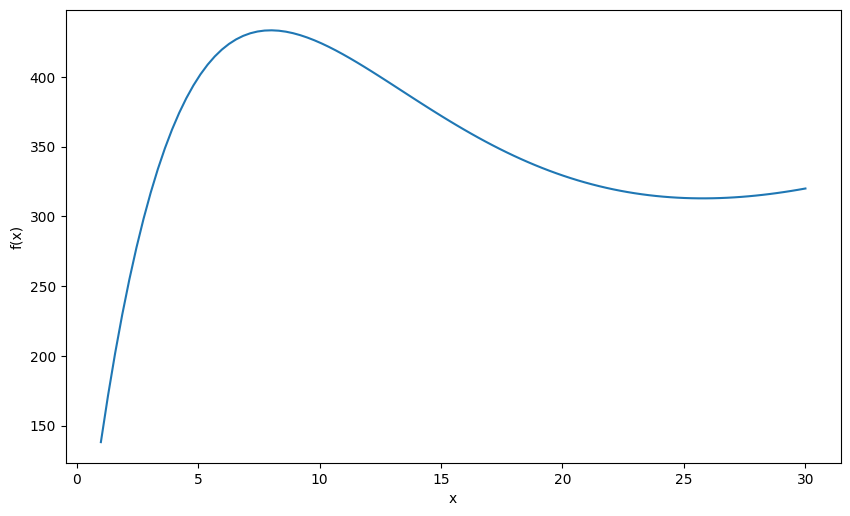

In [3]:
plt.figure(figsize=(10, 6), dpi=100)
bins = 30
xs = np.linspace(1, bins, 100)
ys = true_f(xs)
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Generiamo un campione con fluttuazioni, ad esempio, Poissoniane, intorno alla nostra funzione.

In [4]:
import numpy.random as random
sample_x = np.linspace(1, bins, bins)
sample_y = random.poisson(lam=true_f(sample_x))

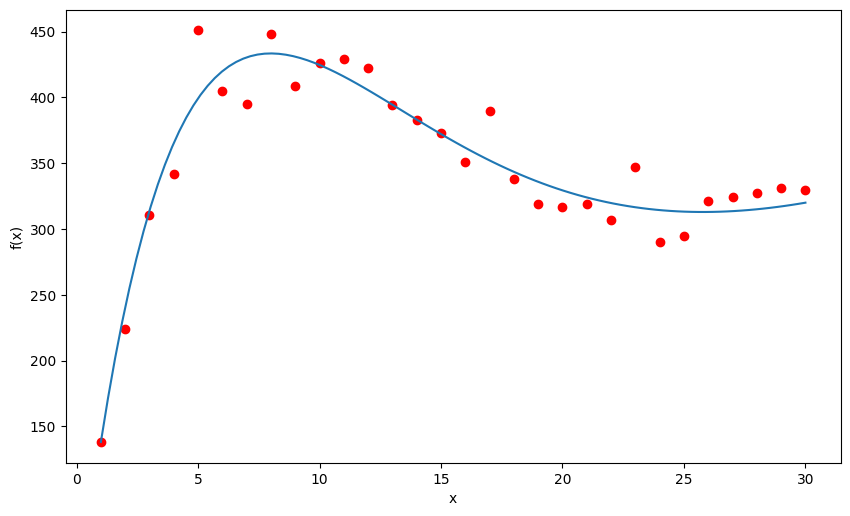

In [5]:
plt.figure(figsize=(10, 6), dpi=100)
xs = np.linspace(1, bins, 100)
ys = true_f(xs)
plt.plot(xs, ys)
plt.scatter(sample_x, sample_y, color='red')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Proviamo *fit* con polinomi di diverso grado $p$ ai punti generati sopra.

Useremo la funzione [```polyval```](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html), per semplicità facciamo il fit assumendo errrori tutti uguali, ma potremmo anche provare con $\sigma=\sqrt{n}$.

In [8]:
from scipy.optimize import curve_fit

def poly(x, *par):
    return np.polyval(par, x)
par, cov = curve_fit(poly, sample_x, sample_y, p0=[1, 100])

In [9]:
par

array([ -0.93214683, 362.9816092 ])

Scegliamo un certo grado del polinomio, es.: $p=3$, e vediamo qual è il risultato del fit.

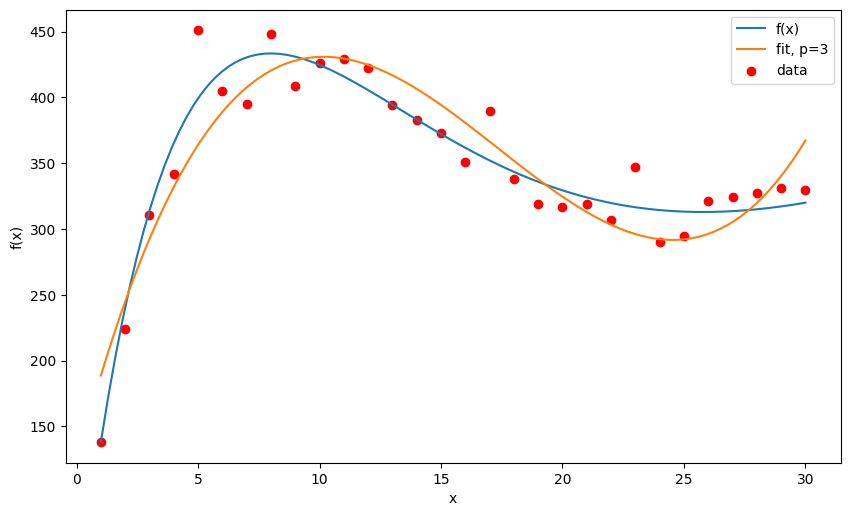

In [10]:
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
ys = true_f(xs)
p = 3
par, cov = curve_fit(poly, sample_x, sample_y, p0=np.zeros(p+1))
fit_ys = poly(xs, *par)
ax.plot(xs, ys, label='f(x)')
ax.plot(xs, fit_ys, label='fit, p={:d}'.format(p))
ax.scatter(sample_x, sample_y, color='red', label='data')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
plt.show()

Il risultato non è molto soddisfacente, perché un polinomio di terzo grado ha deviazioni significative dalla funzione vera.

<span style="color: blue">Cosa cambia se aumentiamo il grado $p$ del polinomio?</span>

Proviamo diversi valori e visualizziamo il risultato.

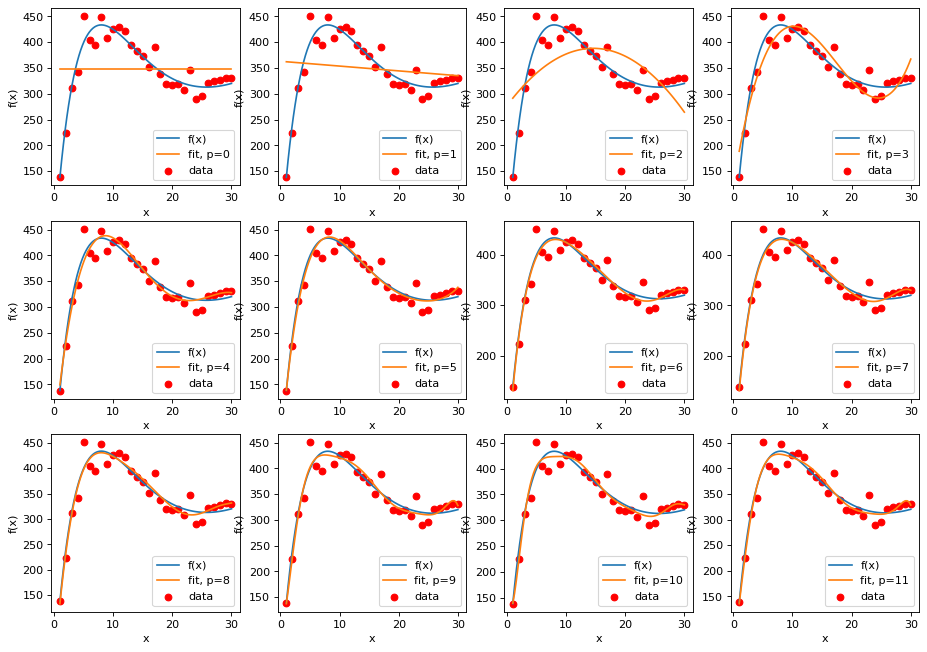

In [12]:
nx, ny = 4, 3
fig, axs = plt.subplots(ny, nx, figsize=(14,10), dpi=80)
ys = true_f(xs)
for p, ax in zip(range(nx*ny), axs.reshape(-1)):
    par, cov = curve_fit(poly, sample_x, sample_y, p0=np.zeros(p+1))
    fit_ys = poly(xs, *par)
    ax.plot(xs, ys, label='f(x)')
    ax.plot(xs, fit_ys, label='fit, p={:d}'.format(p))
    ax.scatter(sample_x, sample_y, color='red', label='data')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
plt.savefig('img_out/bias-var.png', dpi=250)
plt.show()

Più parametri inserisco (quindi: più è grande $p$), più la funzione di fit "segue" le fluttuazioni statistiche dei dati, avvicinandosi alle misure anche più della funzione *vera*. 

Qual è il grado ottimale per il polinomio? Quando bisogna fermarsi ad inserire nuovi parametri nel fit?

Possiamo confrontare la curva di fit ottenuta da questo campione ($y_i^\star$) ad altri campioni  ($y_i^{\star\prime}$)  generati dalla stessa funzione vera misurando.

In sostanza, realizziamo un *toy Monte Carlo*, dove calcoleremo l'*errore quadratico medio atteso*:

$\varepsilon^2 =\displaystyle \mathbb{E}\left\{\frac{1}{n}\sum_{i=1}^n\left[y_i^{\star\prime}-\hat{f}(x_i)\right]^2\right\}$

In [13]:
pmax = 20
v_train = np.empty(pmax)
v_test = np.empty(pmax)
for p in range(pmax):
    par, cov = curve_fit(poly, sample_x, sample_y, p0=np.zeros(p+1))
    fit_y = poly(sample_x, *par)
    v_train[p] = ((fit_y-sample_y)**2).mean()
    v_sum = 0
    n_mc = 100
    for i in range(n_mc):
        sample_y1 = random.poisson(lam=true_f(sample_x))
        v_sum += ((fit_y-sample_y1)**2).mean()
    v_test[p] = v_sum/n_mc
    print("V_train[{p:d}] = {train:.2f}, V_test[{p:d}] = {test:.2f}".format(p=p,train=v_train[p], test=v_test[p]))

V_train[0] = 4249.25, V_test[0] = 4140.47
V_train[1] = 4184.15, V_test[1] = 4014.30
V_train[2] = 2965.69, V_test[2] = 2743.75
V_train[3] = 709.92, V_test[3] = 828.00
V_train[4] = 370.20, V_test[4] = 394.85
V_train[5] = 343.49, V_test[5] = 365.30
V_train[6] = 325.80, V_test[6] = 380.88
V_train[7] = 325.62, V_test[7] = 382.22
V_train[8] = 323.90, V_test[8] = 402.45
V_train[9] = 309.08, V_test[9] = 393.91
V_train[10] = 301.92, V_test[10] = 406.47
V_train[11] = 312.47, V_test[11] = 393.68
V_train[12] = 302.38, V_test[12] = 403.77
V_train[13] = 302.25, V_test[13] = 395.57
V_train[14] = 302.46, V_test[14] = 402.54
V_train[15] = 296.28, V_test[15] = 407.66
V_train[16] = 297.00, V_test[16] = 425.00
V_train[17] = 294.36, V_test[17] = 411.35
V_train[18] = 302.97, V_test[18] = 398.15
V_train[19] = 295.44, V_test[19] = 413.14


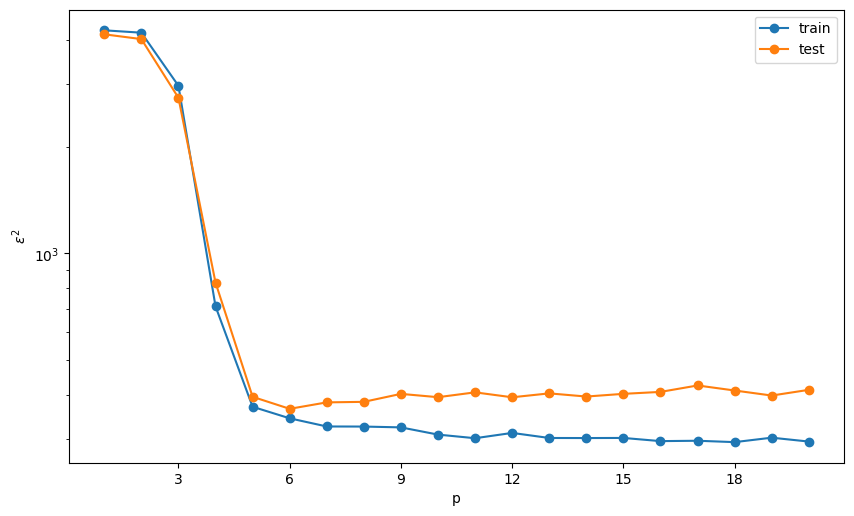

In [15]:
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(np.arange(pmax)+1, v_train, linestyle='-', marker='o', label='train')
plt.plot(np.arange(pmax)+1, v_test, linestyle='-', marker='o', label='test')
plt.xlabel('p')
plt.ylabel(r'$\varepsilon^2$')
plt.legend()
plt.yscale('log')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Overfitting

Quando la curva di fit comincia a seguire le fluttuazioni statistiche del campione anziché il vero modello, presenterà un errore quadratico medio significativamente minore di quello che si otterrebbe confrontando la stessa curva con altri campioni casuali estratti usando la stessa distribuzione teorica.

Parliamo in questi casi di **overfitting**. 

Questo problema è comune ad altre tecniche di **machine learning**, dove gli algoritmi sono *addestrati* (*training*) su campioni di dati, come ad esempio le *neural network*. In quel caso si parla di **overtraining**.

## Decomposizione bias-varianza

L'*errore* quadratico medio per ciascun bin $i$ è definito come il valore atteso della differenza tra la stima $\hat{f}(x_i)$ e la misura $y_i^{\star\prime}$ al quadrato:

$\displaystyle \varepsilon_i^2 = \mathbb{E}\left[\left(\hat{f}(x_i) - y_i^{\star\prime}\right)^2\right]$

Per semplicità di notazione, scriveremo, eliminando anche il pedice $i$:

* $\hat\theta = \hat{f}(x_i)$ (la stima del *fit*)

* $\theta^\star = y_i^{\star\prime}$ (il valore misurato nel campione di test)

* $\theta = y_i$ (il valore vero)

Quindi riscriviamo l'errore quadratico medio (ricordiamo che il pedice $i$ è stato omesso) come:

$\displaystyle \varepsilon^2 = \mathbb{E}\left[\left(\hat{\theta} - \theta^\star\right)^2\right]$

Possiamo inserire nell'espressione il valore atteso di $\hat{\theta}$, $\mathbb{E}[\hat{\theta}]$:

$\displaystyle \varepsilon^2 = \mathbb{E}\left[\left(\hat{\theta} -\mathbb{E}\left[\hat{\theta}\right] +\mathbb{E}[\hat{\theta}]-\theta^\star\right)^2\right]
= \mathbb{E}\left[\left(\hat{\theta} -\mathbb{E}\left[\hat{\theta}\right]\right)^2\right] + \mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta^\star\right)^2\right]
+2\,\mathbb{E}\left[\left(\hat{\theta} -\mathbb{E}\left[\hat{\theta}\right]\right)\left(\mathbb{E}\left[\hat{\theta}\right]-\theta^\star\right)\right]
$

Il termine misto rappresenta un termine di covarianza. Si può dimostrare che è nullo se si considera il valore atteso calcolato indipendentenemnte rispetto a variazioni di $\hat\theta$ e di $\theta^\star$. In sostanza, se si confronta il *fit* ottenuto con un campione (*train*) ad altri campioni estratti indipendentemente (*test*).

Resta quindi:

$\displaystyle \varepsilon^2
= \mathbb{E}\left[\left(\hat{\theta} -\mathbb{E}[\hat{\theta}]\right)^2\right] + \mathbb{E}\left[\left(\mathbb{E}[\hat{\theta}]-\theta^\star\right)^2\right]
$

Il primo termine, $\mathbb{E}[(\hat{\theta} -\mathbb{E}[\hat{\theta}])^2]$, è la varianza di $\hat{\theta}$. Nel secondo termine possiamo inserire il valore vero $\theta$:

$\displaystyle \varepsilon^2 = 
\mathbb{V}\mathrm{ar}\left[\hat{\theta}\right] + \mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta + \theta - \theta^\star\right)^2\right] = \\
= \mathbb{V}\mathrm{ar}\left[\hat{\theta}\right] + 
\mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta\right)^2\right] + \mathbb{E}\left[\left(\theta - \theta^\star\right)^2\right] 
+2\,\mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta\right)\left(\theta - \theta^\star\right)\right]
$

Ancora il termine di covarianza è nullo. Resta quindi:

$\displaystyle \varepsilon^2 = 
\mathbb{V}\mathrm{ar}\left[\hat{\theta}\right] + 
\mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta\right)^2\right] + 
\mathbb{E}\left[\left(\theta - \theta^\star\right)^2\right]
$

Il primo dei due valori di aspettazione che seguono la varianza di $\hat\theta$ non contiene quantità variabili, ed è pari al quadrato del *bias*:

$\mathbb{E}\left[\left(\mathbb{E}\left[\hat{\theta}\right]-\theta\right)^2\right] = 
\left(\mathbb{E}\left[\hat{\theta}\right]-\theta\right)^2 = 
\mathbb{B}\mathrm{ias}\left[\hat{\theta}\right]^2$

Il secondo è la varianza di $\theta^\star$. Quindi la decomposizione di $\varepsilon^2$ è completa:

$\displaystyle \varepsilon^2 = 
\mathbb{V}\mathrm{ar}\left[\hat{\theta}\right] + 
\mathbb{B}\mathrm{ias}\left[\hat{\theta}\right]^2  + \mathbb{V}\mathrm{ar}[\theta^\star]
$

L'ultimo termine, $\mathbb{V}\mathrm{ar}[\theta^\star]$, è la varianza intrinseca dell'osservazione $\theta^\star$. Non dipende quindi dal modello di *fit*, e non è riducibile.

Bias e varianza di $\hat{\theta}$, invece, dipendono dal modello di fit. Vedremo che non è possibile ridurle entramble, e va quindi scelto un valore che permetta di ottenere il compromesso ottimale tra varianza e bias.

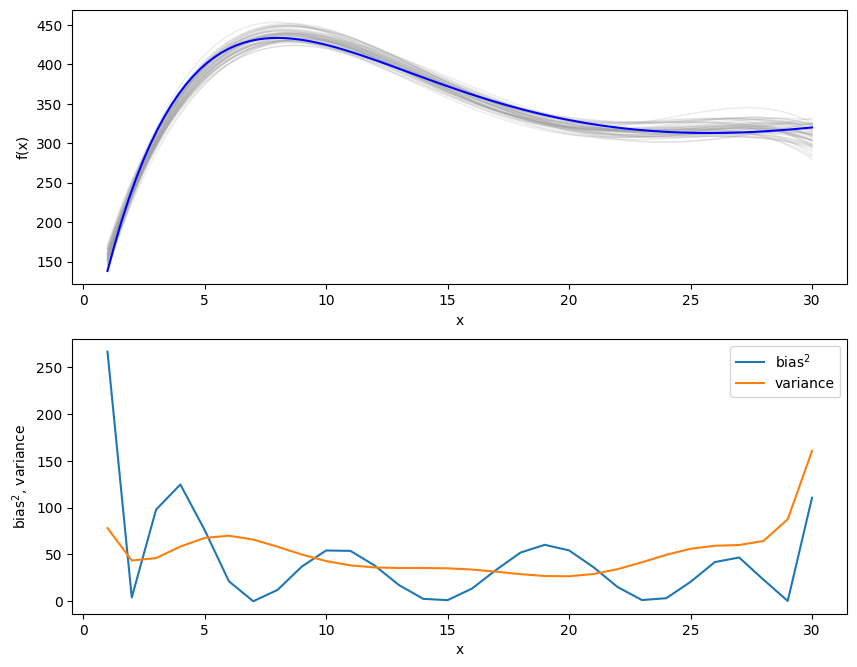

In [16]:
bias2 = np.zeros(bins)
variance = np.zeros(bins)
s = np.zeros(bins)
s2 = np.zeros(bins)
p = 4
fig, ax = plt.subplots(2, figsize=(10,8), dpi=100)
ys = true_f(xs)
n_mc = 50
for i in range(n_mc):
    sample_y1 = random.poisson(lam=true_f(sample_x))
    par, cov = curve_fit(poly, sample_x, sample_y1, p0=np.zeros(p+1))
    ax[0].plot(xs, poly(xs, *par), color='#a0a0a0', linewidth=1, alpha=0.2)
    fit_ys = poly(sample_x, *par)
    s += fit_ys
    s2 += fit_ys**2
s /= n_mc
s2 /= n_mc
bias2 = (s - true_f(sample_x))**2
variance = s2 - s**2
ax[0].plot(xs, true_f(xs), color='blue')
ax[0].set_xlabel('x')
ax[0].set_ylabel('f(x)')
ax[1].plot(sample_x, bias2, label='bias$^2$')
ax[1].plot(sample_x, variance, label='variance')
ax[1].set_xlabel('x')
ax[1].set_ylabel('bias$^2$, variance')
ax[1].legend()
plt.show()

Consideriamo ora la media di bias e varianza su tutti i bin al variare del grado del polinomio $p$.

In [17]:
pmax = 19
bias2 = np.zeros(pmax)
variance = np.zeros(pmax)
ys = true_f(xs)
for p in range(pmax):
    s = np.zeros(bins)
    s2 = np.zeros(bins)
    n_mc = 20
    for i in range(n_mc):
        sample_y1 = random.poisson(lam=true_f(sample_x))
        par, cov = curve_fit(poly, sample_x, sample_y1, p0=np.zeros(p+1))
        fit_ys = poly(sample_x, *par)
        s += fit_ys
        s2 += fit_ys**2
    s /= n_mc
    s2 /= n_mc
    b2 = (s - true_f(sample_x))**2
    v = s2 - s**2
    bias2[p] = b2.mean()
    variance[p] = v.mean()
    print("p = {:d}, bias = {:.2f}, variance = {:.2f}".format(p, bias2[p], variance[p]))

p = 0, bias = 3811.54, variance = 9.61
p = 1, bias = 3697.20, variance = 24.01
p = 2, bias = 2420.48, variance = 30.01
p = 3, bias = 473.69, variance = 47.50
p = 4, bias = 48.70, variance = 48.59
p = 5, bias = 6.61, variance = 53.37
p = 6, bias = 3.48, variance = 64.72
p = 7, bias = 3.82, variance = 82.42
p = 8, bias = 5.14, variance = 100.61
p = 9, bias = 3.24, variance = 105.58
p = 10, bias = 2.82, variance = 107.44
p = 11, bias = 8.35, variance = 122.46
p = 12, bias = 3.34, variance = 128.17
p = 13, bias = 4.71, variance = 123.72
p = 14, bias = 10.84, variance = 144.32
p = 15, bias = 4.08, variance = 139.60
p = 16, bias = 6.46, variance = 130.04
p = 17, bias = 8.13, variance = 137.83
p = 18, bias = 3.48, variance = 138.91


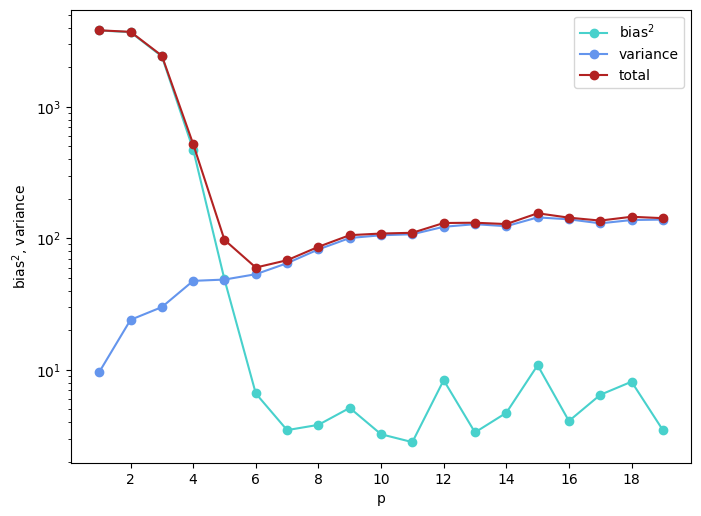

In [18]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(pmax)+1, bias2, linestyle='-', marker='o', color='mediumturquoise', label='bias$^2$')
plt.plot(np.arange(pmax)+1, variance, linestyle='-', marker='o', color='cornflowerblue', label='variance')
plt.plot(np.arange(pmax)+1, bias2+variance, linestyle='-', marker='o', color='firebrick', label='total')
plt.xlabel('p')
plt.ylabel('bias$^2$, variance')
plt.legend()
plt.yscale('log')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Nota

Abbiamo potuto calcolare il bias perché conoscevamo la funzione vera. Non sempre questo è possibile. In questi casi, il problema va "calibrato" in un caso in cui la funzione vera è nota.

### Approfondimenti

Da notare che gli articoli statistici in genere usano una notazione che non è sempre usuale per i fisici.

* [Bias-Variance Tradeoff ](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html)
* [MSE and Bias-Variance decomposition](https://towardsdatascience.com/mse-and-bias-variance-decomposition-77449dd2ff55)
* [Understanding Generalization Error in Machine Learning](https://medium.com/@yixinsun_56102/understanding-generalization-error-in-machine-learning-e6c03b203036)
* [A. Solari, INFN School of Statistics, Machine Learning, 1/2](https://agenda.infn.it/event/16360/contributions/33711/attachments/64097/77368/aldo-solari-1.pdf)
    